# Likelihood
### open source data quality monitor

Colin Jemmott
2020

Have you ever found out an ETL job failed because a customer called?  You ever retrain a machine learning model in production just to find out the data changed out from under you?  Have a dashboard break because new data violated your assumptions?

### Approach

Everything is probability (or, rather [surprise](https://en.wikipedia.org/wiki/Entropy_(information_theory)#Introduction)!).  Works on a two dataframes for now - you have to get the data.

Batch job, you pass in training and test.

Taxonomy of problems for initial launch:
- New values in categorical - bootstrapping
- Missing values - bootstrapping (Nan is just another category)
- Outliers in counts (missing or spike) - prophet

To Do:

- Outliers in counts of groups - bootstrapping
- Outliers in values - kernel density?

Later:
- Outliers in correlation between categories - assocation rules / Bayesian network / just conditional probability
- Delayed data (I think we need a writtenAt timestamp)
- Multi-table: check joins
- PCA?  Other anomaly detection?
- Multitenant

### Tips

Some of the analysis assumes that the data is stationary (ergodic).  If that is a bad assumption it might make sense to trim history.  maxTrainingSizeMultiple controls that.

### To Do

- Change out data for something public (SDPD?)
- Write params to JSON
- preprocessor on bootsrtapping for columns with tons of entries.  Also numerical columns?
- Throw a warning or error if the testing sample is too small?

In [59]:
import pandas as pd
import math as mt
import dateutil
from datetime import datetime, timedelta
import requests as rd
import numpy as np
import scipy.stats
from sklearn import neighbors, decomposition

# Get data

Not part of the actual product, but here for ease of testing.

In [ ]:
import os
import pandas as pd
from datetime import datetime, timedelta


N_days = 90
batchHours = 7*24 # this grabs the most recent chunk and looks for differences with the remainder


# parameters (will put into JSON config file later)
params = {"fName": "pd_calls_for_service_2020_datasd.csv", # local CSV file only right now
          "ts": "date_time", # Timestamp for when the event happened in the world
          "bootstrapResamples":1000, # should probably be 10k for better accuracy, but much worse speed
          "maxTrainingSizeMultiple":10, # if there is more than X times more training data, trim to most recent
          "maxCategories":100, # maximum number of categories in a column - if higher we skip
          "minCategoryCount":10, # don't report boostrap surprise if a category has lower count
         }

## Load data, split into training and test

In [ ]:
df = pd.read_csv("pd_calls_for_service_2020_datasd.csv")
if(df.shape[0] <= 1000):
    print("Warning: small data set might produce inaccurate results")
df['ts'] = df[params['ts']]
print(df)
#.apply(dateutil.parser.parse, ignoretz=True) # could speed this up for ISO8601 - currently slow.
df['ts'] =  pd.to_datetime(df['ts'], format='%Y%m%d %H:%M:%S')
maxTs = max(df['ts'])
#df = df.assign(date_time = df.get("date_time").apply(datetime.strptime, args = ("%d/%m/%Y %H:%M:%S")))
batchTs = maxTs - timedelta(hours = batchHours)
testDf = df[df['ts'] > batchTs]
trainDf = df[df['ts'] < batchTs]

In [ ]:
trainDf.keys()

In [ ]:
max(trainDf['ts'])

In [ ]:
# Helpers and Math
def pValue(data, threshold):
    p_larger = sum(np.array(data) >= threshold) / len(data)
    p_smaller = sum(np.array(data) <= threshold) / len(data)
    p = min(p_larger, p_smaller)

    # only use gaussian p-value when there is variation, but bootsrap p = 0
    stdev = np.std(data)
    if stdev == 0 or p != 0:
        p_gauss = p
    else:
        p_gauss = scipy.stats.norm(np.mean(result['bootstrap_counts']), stdev).cdf(result['count'])
        p_gauss = min(p_gauss,1-p_gauss)
    return p_gauss

def trimTraining(trainDf, params):

    # trim to most recent
    trainDf = trainDf.sort_values(params['ts'], ascending =False)
    trainDfTrimmed = trainDf[:params['maxTrainingSizeMultiple']*len(testDf)]
    
    return trainDfTrimmed

In [ ]:
# get all of the string columns
columnNames = []
for columnName in testDf.keys():
    if (type (testDf[columnName].iloc[0])) == str:
        columnNames.append(columnName)
print(columnNames)
bootstrapDf = trimTraining(trainDf, params)
        
# set up dict, add counts
results = {}
for columnName in columnNames:
    # if it isn't a string column, reject it
    if type(testDf[columnName].iloc[0]) != str:
        continue
    categories = (bootstrapDf[columnName].append(testDf[columnName])).unique()
    if len(categories) > params['maxCategories']:
        continue
    
    results[columnName] = {}
    testCounts = testDf[columnName].value_counts(dropna = False)
    for i in np.arange(1,len(categories) -1):
        if(pd.isna(categories[i])):
            categories = np.delete(categories, i)  
    for category in categories:
        results[columnName][category] = {'bootstrap_counts':[],
                                        'count':testCounts.get(category,0)}
# resample, add boostrap counts
for ii in range(params['bootstrapResamples']):
    # Draw random sample from training
    sampleDf = bootstrapDf.sample(len(testDf), replace=True)
    for columnName in results.keys():
        # count by category
        trainCounts = sampleDf[columnName].value_counts(dropna = False)
        # put results in dict
        for category in results[columnName].keys():
            boostrapCount = trainCounts.get(category,0)
            results[columnName][category]['bootstrap_counts'].append(boostrapCount)
              
# convert to records, add p-values
bootstrap_results = []
for columnName in results.keys():
    for category in results[columnName].keys():
        result = results[columnName][category]
        
        estimatedCount = int(np.round(np.mean(result['bootstrap_counts'])))
        # don't report entries with very low predicted and actual counts
        if estimatedCount < params['minCategoryCount'] and result['count'] < params['minCategoryCount']:
            continue
        
        p = pValue(result['bootstrap_counts'],result['count'])
        categoryName = category
        if not category:
            categoryName = "NULL"
        
        bootstrap_results.append({"column":columnName,
                           "category":categoryName,
                           "count":result['count'],
                           "p": p,
                           "estimated_count":estimatedCount,
                           })
if(np.count_nonzero(p)>0):
    resultsDf = pd.DataFrame.from_records(bootstrap_results).sort_values('p')
    resultsDf['surprise'] = -np.log2(resultsDf['p'])

In [ ]:
resultsDf.head(70)

# Timeseries forecast (prophet)

Installing prophet is a major pain, especially on Windows.  Details: https://facebook.github.io/prophet/docs/installation.html

Following the lead from Seismic interns: https://medium.com/seismic-data-science/anomaly-detection-using-prophet-a5dcea2c5473

Decided to go hourly, but could change to day with a few tweaks.

In [ ]:
from fbprophet import Prophet

In [ ]:
def truncateTs(ts):
    return ts.replace(minute=0, second=0,  microsecond=0)

In [ ]:
truncatedData = trainDf['ts'].apply(truncateTs)
groupedCounts = truncatedData.value_counts()

prophetDf = pd.DataFrame({'ds':groupedCounts.index,'y':np.log10(groupedCounts.values)})
prophetDf

In [ ]:
# find number of hours to preduct: ceil of hours in testDf
timeDelta = max(testDf['ts']) -min(testDf['ts'])
hours = int(timeDelta.days*24 + timeDelta.seconds/(60*60))+1
 
# Train model
m = Prophet(#daily_seasonality = True, 
            #yearly_seasonality = False, 
            #weekly_seasonality = True, 
            #growth='linear',
            interval_width=0.68 # one sigma
           )
m.add_country_holidays(country_name='US')

m.fit(prophetDf)

future = m.make_future_dataframe(periods = hours, freq = 'H')
fcst = m.predict(future)

In [ ]:
# group the test data
truncatedData = testDf['ts'].apply(truncateTs)
groupedCounts = truncatedData.value_counts()

prophetTestDf = pd.DataFrame({'ds':groupedCounts.index,
                              'y':np.log10(groupedCounts.values),
                              'y_linear':groupedCounts.values})

# find p-value
prophet_results = []

for ii in range(len(prophetTestDf)):
    ts = prophetTestDf['ds'][ii]
    fcstExample = fcst[fcst['ds'] == ts]
    mean = fcstExample['yhat'].iloc[0]
    stdev = (fcstExample['yhat_upper'].iloc[0] - fcstExample['yhat_lower'].iloc[0])/2
    p = scipy.stats.norm(mean, stdev).cdf(prophetTestDf['y'][ii])
    p = min(p,1-p)

    prophet_results.append({"column":"Forecast",
                       "category":str(ts),
                       "count":prophetTestDf['y_linear'][ii],
                       "p": p,
                       "estimated_count":int(np.round(np.power(10,mean))),
                       })
    
prophetResultsDf = pd.DataFrame.from_records(prophet_results).sort_values('p')
prophetResultsDf['surprise'] = -np.log2(prophetResultsDf['p'])
prophetResultsDf

In [ ]:
# plotting for debug only
fig = m.plot(fcst)
fig = m.plot_components(fcst)

# Kernel Density Implementation Below

In [ ]:
#obtaining user input
#https://www.nbastuffer.com/2019-2020-nba-team-stats/
def inp(default = 1, default2 = "https://www.nbastuffer.com/2019-2020-nba-team-stats/"):
    if(default2 != "https://www.nbastuffer.com/2019-2020-nba-team-stats/"):
        nam = input()
    else:
        nam = default2
    frame = pd.read_html(nam)
    first_table = frame[default]
    return first_table
first_table = inp(1,"input")

In [ ]:
first_table

### Stat Computations for Formulas Found Below

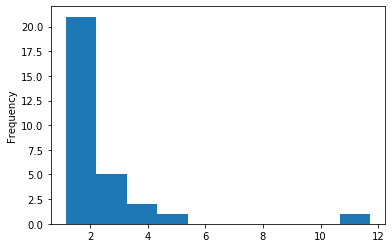

In [60]:
def getParam(default = "PTS/GMPoints Per GameAverage points per game"):
    #Stuff beyond here focuses on kernel density, it is a work in progress
    if(default != "PTS/GMPoints Per GameAverage points per game"):
        print("Enter the column name you'd like to get a kernel density estimation for:")
        #Prompting user for input and calculating basic statistics, bandwidth temporarily set to .05
        #For testing purposes
        inp = input()
    else:
        inp = default
    stat = first_table.get(inp)
    return stat
stat = getParam()
#Index for purpose of making table nicer
def getIndex(indx = "TEAM"):
    if(indx!="TEAM"):
        print("Please enter the name of the column you'd like to serve as your index:")
        indx = first_table.get(input())
    else:
        indx = first_table.get(indx)
    return indx
indx = getIndex()

#Plotting Data initially
stat.plot(kind  = "hist")
avg = stat.mean()
density = np.array([])
n = first_table.shape[0]
dev = np.std(stat)

kernelEstimations = pd.DataFrame()

The Kernel Estimation for a Gaussian, Cosine, Triangular, and Parabolic Kernel are found below, metric used for surprise computation will be based on their average. Idea is: if between them we can found a standard density, we can find values that are more likely to be outliers. Other idea: find outliers for every one and check for commonalities.

### Scikit learn citation because their software is utilized
@article{scikit-learn,
 title={Scikit-learn: Machine Learning in {P}ython},
 author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V.
         and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P.
         and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and
         Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
 journal={Journal of Machine Learning Research},
 volume={12},
 pages={2825--2830},
 year={2011}
}

In [61]:
# Using cosine kernel function to get estimate for log density
def cosKernel(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'cosine').fit(stat)
    cos_density = l.score_samples(stat)
    return cos_density

In [ ]:
# Using gaussian kernel function to get estimate for log density
def gaussKernel(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'gaussian').fit(stat)
    density = l.score_samples(stat)
    return density

In [ ]:
# Using linear kernel function to get estimate for log density
def expKernel(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'exponential').fit(stat)
    triDensity = l.score_samples(stat)
    return triDensity

In [ ]:
# converted to Proportion for u < 1 supported functions
def toProp(number):
    return number/max(number)

In [ ]:
# Using epanechnikov kernel function to get estimate for log density
def parabolicKernel(stat):
    stat = stat.to_numpy().reshape(-1,1) 
    l = neighbors.KernelDensity(kernel = 'epanechnikov').fit(stat)
    epDensity = l.score_samples(stat)
    return epDensity

In [ ]:
#Creates normal distribution (we have standardized data) and calculates P-value with the null hypothesis being no systematic error
def retPVal(col):
    #Since we have a normal distribution, starting by obtaining the z-score
    mean = col.mean()
    std = np.std(col)
    array = np.array([])
    for i in np.arange(len(col)):
        array = np.append(array, col.iloc[i] - mean)
    
    #Now obtaining legitimate p-values
    z_scores = array/std
    for l in np.arange(len(z_scores)):
        cdf = st.norm.cdf(z_scores[l])
        z_scores[l] = min(cdf, 1-cdf)
    return pd.Series(z_scores, index = col.index)

## Kernel Values Data

In [ ]:
# Assigning initial kernal estimations
def kernelEstimator(indx, stat):
    kernelEstimate = pd.DataFrame()
    kernelEstimate = kernelEstimate.assign(Data_Index = indx, Data_Point = stat,Gaussian = gaussKernel(stat),
                                               Epanechnikov = parabolicKernel(stat), Exponential = expKernel(stat),
                                               Cosine = cosKernel(stat))
    # temporary sort for some visualization of surprise
    kernelEstimate = kernelEstimate.sort_values(by = "Gaussian", ascending = False)
    return kernelEstimate
kernelEstimation = kernelEstimator(indx, stat)
kernelEstimation

In [ ]:
# Calculating their average
def surprise_estimator(kernelEstimation):
    numDevMax = (kernelEstimation.get("Data_Point").max() - kernelEstimation.get("Data_Point").mean())/kernelEstimation.get("Data_Point").std()
    numDevMin = (kernelEstimation.get("Data_Point").min() - kernelEstimation.get("Data_Point").mean())/kernelEstimation.get("Data_Point").std()
    numDev = max(numDevMax, numDevMin)
    if(numDev > 3.2):
        metric = retPVal(kernelEstimation.get("Exponential"))
    elif((numDev <=3.2) & (numDev >= 2)):
        metric = retPVal(kernelEstimation.get("Gaussian"))
    else:
        metric = retPVal(kernelEstimation.get("Exponential")+kernelEstimation.get("Epanechnikov"))          
    # Surprise Metric
    kernelEstimation  = kernelEstimation.assign(Surprise = -np.log2(metric))
    kernelEstimation = kernelEstimation.sort_values(by = "Surprise", ascending = False)
    return kernelEstimation
kernelEstimation = surprise_estimator(kernelEstimation)
kernelEstimation

In [ ]:
# A grouping of the entire kernel estimation process
def surprise_Table(Table, index = "TEAM"):
    temp = pcaPrep(Table)
    if(isinstance(index, str)):
        index = Table.get(index)
    sum_surprise  = pd.Series(np.zeros(Table.shape[0]))
    for col in temp.columns:
        stat = temp.get(col)
        KernelTable = kernelEstimator(index, stat)
        KernelTable = surprise_estimator(KernelTable)
        Table[col] = KernelTable.get("Surprise")
        sum_surprise+=Table[col]
    sum_surprise = sum_surprise.array
    if(not isinstance(index, str)):
        Table = Table.set_index(index)
    Table = Table.assign(mean_surprise = np.round(sum_surprise/Table.shape[1],2))
    # Sorting table for easier visualization
    Table = Table.sort_values(by = "mean_surprise", ascending  = False)
    return Table
modTable = first_table
surpriseTable = surprise_Table(first_table)
surpriseTable

The Exponential Density should apply to a more fat-tailed distribution, and makes less assumption of outliers, others assume a less spread out (parabolic and cosine) or normal (gaussian) distribution. To truly quantify an outlier, exponential density should be used.

# Visualization Below

In [ ]:
surpriseTable.plot(kind = "barh", y = "mean_surprise")

In [ ]:
surpriseTable.get("mean_surprise").plot(kind = "hist")

# PCA and Singular Value Decomp for Cross Column Correlation Lie Ahead

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import smtplib
import scipy.stats as st

In [ ]:
def loader(first_table):
    # Giving user option to change dataset
    print("Would you like to change the data set you are working with?")
    if(input().upper() == "YES"):
        print("Enter the URL below:")
        nam = input()
        frame = pd.read_html(nam)
        table = frame[1]
        return table
    else:
        return first_table
first_table = loader(first_table)
print("\ndataset below:")
first_table

In [ ]:
def pcaPrep(first_table):
# Finding all numerical components of the table so that pca can function
    tabl = first_table.select_dtypes(include = [np.number])
    tabl = tabl.dropna(1)
    return tabl

def obtain_variance_table(first_table):
    tabl = pcaPrep(first_table)
    scaled_data = StandardScaler().fit_transform(tabl)
    # Creating a PCA object 
    pca = PCA(n_components = (tabl.shape[1]))
    pcaData = pca.fit_transform(scaled_data)
    infoFrame = pd.DataFrame().assign(Column = ["PC" + str(i) for i in range(tabl.shape[1])], Variance_ratio = pca.explained_variance_ratio_ )
    return infoFrame
obtain_variance_table(first_table)

In [ ]:
def obtainPCAVals(componentNum, scaled_data):
    pca = PCA(n_components = componentNum)
    print(scaled_data)
    pcaData = pca.fit_transform(scaled_data)
    return pcaData

In [ ]:
# Deciding how many columns need to be used: utilizing threashold of 95% of the explained variance
def elementDecider(infoFrame):
    numSum = 0
    counter = 0
    for i in infoFrame.get("Variance_ratio"):
        if(numSum < .95):
            numSum += i
            counter+=1
    return counter

#Reducing dimensionality of data into pc's, only storing what is neccessary
def reducedData(infoFrame,  scaled_data, indx):
    numCols = elementDecider(infoFrame)
    pcaData = obtainPCAVals(numCols, scaled_data)
    pcaFrame = pd.DataFrame(pcaData)
    if(not isinstance(indx, str)):
        pcaFrame = pcaFrame.set_index(indx)
    return pcaFrame

#Visualization tool for seeing grouping of elements by pc
def displayReducedData(pcaVals, xNum = 0, yNum = 1):
    # Ensuring that the elements given do not overacess table 
    if(xNum < pcaVals.shape[1]) & (yNum < pcaVals.shape[1]):
        pcaVals.plot(kind = "scatter", x = 2, y = 3)
    else:
        print("You have overaccessed the number of elements, keep in mind there are only " + str(pcaVals.shape[1]) + " elements")
    

In [ ]:
#Summing p-values because PCA serves to check for systematic bias, whereas kernel density checks for accuracy
def sumRows(pcaVals):
    sumArray = np.zeros(pcaVals.shape[0])
    for i in np.arange(pcaVals.shape[1]):
        values = pcaVals.get(str(i)).array
        sumArray += values
    sumArray /= pcaVals.shape[1]
    #After obtaining sum, the average deviation from the expected value is averaged out, not taking in absolute value
    # to check for systematic error
    return sumArray

    
def pcaRowOutliers(pcaVals):
    P_val_table = pd.DataFrame()
    #Creating a table of all the PCA p-values
    for col in np.arange(0,pcaVals.shape[1]):
        P_vals =  retPVal(pcaVals.get(col))
        i = str(col)
        P_val_table[i] = P_vals
    print("The P-Values of each PCA score found below: \n")
    print(P_val_table)
    totalVar = sumRows(P_val_table)
    
    #Calculating surprise by taking negative log
    newVals = pcaVals.assign(Surprise = -np.log2(totalVar))
    newVals = newVals.sort_values(by = "Surprise", ascending = False)
    return newVals

In [ ]:
def runPCA(table, index):
    processing_table = pcaPrep(table)
    variance_table = obtain_variance_table(table)
    pcaVals = reducedData(variance_table, StandardScaler().fit_transform(processing_table), table.get(index))
    new_pca = pcaRowOutliers(pcaVals)
    return new_pca
new_pca = runPCA(first_table, 'TEAM')

Now that we have found individual outliers with both a column approach and a row-based approach, we group the 2 approaches using naive bayes in a manner that is easy to read. Idea: group by sum of surprise so outliers appear at the top!

In [ ]:
def pca_kernel_combo(pcaTable,kernelTable):
    pcaSurpriseCol = new_pca.get("Surprise")
    temp = pcaPrep(kernelTable)
    for column in temp.columns:
        kernelTable[column] = (kernelTable[column].multiply(pcaSurpriseCol)).apply(np.sqrt)
    kernelTable = kernelTable.sort_values(by = "mean_surprise", ascending = False)
    return kernelTable
surpriseTable = pca_kernel_combo(new_pca, surpriseTable) 
surpriseTable

## Attaching Program to Data Set Below

In [63]:
table = pd.read_csv("http://seshat.datasd.org/budget/budget_operating_datasd.csv", nrows = 500)

In [113]:
print(table.head(69))

      amount  report_fy budget_cycle     fund_type  fund_number  \
0   379363.0         17      adopted  General Fund       100000   
1   139001.0         17      adopted  General Fund       100000   
2     7650.0         17      adopted  General Fund       100000   
3     7778.0         17      adopted  General Fund       100000   
4     7650.0         17      adopted  General Fund       100000   
5     3646.0         17      adopted  General Fund       100000   
6    36109.0         17      adopted  General Fund       100000   
7     3066.0         17      adopted  General Fund       100000   
8     1207.0         17      adopted  General Fund       100000   
9      690.0         17      adopted  General Fund       100000   
10    5501.0         17      adopted  General Fund       100000   
11   17745.0         17      adopted  General Fund       100000   
12     310.0         17      adopted  General Fund       100000   
13   11441.0         17      adopted  General Fund       10000

In [ ]:
table = (table.groupby("account_number").mean()).reset_index()
print(table)
def main(table):
    kernelTable = surprise_Table(table, 10)
    pcaTable = runPCA(table, table.get("account_number"))
    combo = pca_kernel_combo(pcaTable, kernelTable)
    return designer(combo)
main(table)

In [ ]:
import schedule
import time

In [ ]:
schedule.every().friday.do(main)

# Tackling the Categorical Question Below

The following are several categorical questions that could be tackled with this program, ultimately, this will be used in the report which assesses flaws in the data. I perceive the functionality to work something like a data spellcheck. 

This attempts to answer the questions above but with categorical data: is there a problem and if so where is it? However it is different in that this will also attempt to answer why.

The program will be built upon the principals of entropy and will work something like this: languages have a structure and rules. There is a certain grammar to be followed, and the more strict the grammar is the lower a systems relative entropy (its entropy relative to the maximum entropy that could be had). Thus, more structure  = stricter interpretation of the data and outliers. If something follows the rule, it airs on the side of redundancy. Otherwise, it airs on the side of the entropy of the rule. Thus, the easiest approach to finding a numerical outlier within data is to build rules that are as abstract and all encompassing as possible (so as to avoid the need for context), and obtain the entropy of every data point in regards to whether it does/ does not follow the rules. Naturally, the data which does not follow the rules is bound to have greater entropy, but particularly if the rule is strict.

However, if the data set is terribly structured and the data frequently breaks rules then it is not at all surprising for a rule to be broken. If, say, every bit of data broke an entirely different rule once (the most extreme case of a dataset having a massive total entropy), it would be not at all surprising to see data break rules. Thus, the surprise will be measured as a true metric of relative entropy, meaning that we are measuring the anomaly of all the rules a piece of data broke: relative to how often and severly rules are broken. This will put things in better context. The why piece of the question after measuring this should be easy: for each piece of data, the program will store which rules the data broke: and how strict these rules were.

In [111]:
import Levenshtein as leven
from pandas.api.types import is_numeric_dtype

In [202]:
# Will examine whether or not a column is categorical, giving the user the opportunity to add additional numeric columns
def identifyCategorical(surpriseFrame):
    categorical_list = []
    for col in surpriseFrame.columns:
        if(not(is_numeric_dtype(surpriseFrame[col]))):
            categorical_list.append(col)
    
    # Allows fixing of default assumption that numeric columns aren't categorical
    print("Are there any numeric Columns you would consider categorical?(yes/no)")
    while(input().upper() == "YES"):
        print("Enter one such column:")
        categorical_list.append(input())
        print("Any more?")
    return categorical_list

# We want to preserve initial NaN's, so passing first_table instead of modified surpriseTable
categorical_columns = identifyCategorical(table)
categorical_columns

Are there any numeric Columns you would consider categorical?(yes/no)
no


['budget_cycle', 'fund_type', 'dept_name', 'account']

Below is categorical approach, which has been updated so some remnants of previous code might remain

In [155]:
# Determines uniqueness ratios to determine whether a unique/nonunique value is an anomaly
#Returns ratios for metaData data frame in next method
def unique_ratio(surpriseFrame, categorical_columns):
    ratios = np.array([])
    
    # Removing NaN's because they can be treated as 0 for this purpose, this way we can identify them as a non-unique value
    surpriseFrame = surpriseFrame.replace({np.nan:0})
    for column in categorical_columns:
        ratios = np.append(ratios, len(np.unique(surpriseFrame.get(column).to_numpy()))/ surpriseFrame.shape[0])   
    return ratios

#Obtaining sample size for sake of metadata comparisons and possible p-value calculation PER sample size
def sampleSizeArray(table, categorical_columns):
    array = np.array([])
    for i in categorical_columns:
        array = np.append(array, table.shape[0])
    return array

# Builds DataFrame full of metadata off of given training set that is to be used for later comparisons
def metaData(table):
        metadata_table = pd.DataFrame()
        categorical_cols = identifyCategorical(table)
        uniqueness = unique_ratio(table, categorical_cols)
        
        # Number and ratio of unique values to be used for detection of anomalies in the appearance of new values
        metadata_table = metadata_table.assign(categorical_columns = categorical_cols, column_unique_ratio = uniqueness)
        metadata_table = metadata_table.assign(number_unique_values = np.round(uniqueness*table.shape[0]))
        metadata_table = metadata_table.assign(nan_ratio = nan_ratio(table, categorical_cols)).set_index("categorical_columns")
        
        #obtaining sample size, number of html tags
        metadata_table = metadata_table.assign(based_off_sample = sampleSizeArray(table, categorical_cols) )
        metadata_table = metadata_table.assign(num_html_tags = contains_HTML(table, categorical_cols))
        return metadata_table
metadata1 = metaData(table.head(50))
metadata1


Are there any numeric Columns you would consider categorical?
no


,column_unique_ratio,number_unique_values,nan_ratio,based_off_sample,num_html_tags
categorical_columns,,,,,
budget_cycle,0.02,1.0,0.0,50.0,0.0
fund_type,0.02,1.0,0.0,50.0,0.0
dept_name,0.02,1.0,0.0,50.0,0.0
account,0.92,46.0,0.0,50.0,0.0


**Calculating anomaly for classification: type, whether it is an nan, and the length of the data**

In [293]:
# Returns suprise of type classification
def types(column):
    value_types = column.apply(classifier)
    counts  = value_types.value_counts(normalize = True)
    print(counts)
    index = counts.index
    values = counts.values
    probs = value_types.apply(giveProb, args = (np.array(index), np.array(values)))
    surpriseVal = probs.apply(surprise)
    return surpriseVal

# Obtains the type of value, even if it is currently contained within a string
def classifier(value):
    value = str(value)
    # Boolean check done manually: this is an easy check
    if(('True' in value) or ('False' in value )):
        return 'boolean'
    else:
        if(value.isnumeric()):
            return 'number'
        else:
            return 'string'
    
# Takes in a column and returns the surprise of each nan value being present (True) or not being present (False)
def nans(column):
    nan_values = column.apply(isNan)
    counts  = nan_values.value_counts(normalize = True)
    index = counts.index
    values = counts.values
    probs = nan_values.apply(giveProb, args = (np.array(index), np.array(values)))
    surpriseVal = probs.apply(surprise)
    return surpriseVal

# Takes in a column and returns the surprise of the length of each value in the column: the first and simplest of probabilistic tests
def lenCount(column):
    column = column.apply(str)
    counts = column.apply(len).value_counts(normalize = True)
    index = counts.index
    values = counts.values
    column = column.apply(len)
    probs = column.apply(giveProb, args = (np.array(index), np.array(values)))
    surpriseVal = probs.apply(surprise)
    return surpriseVal

# Calculates the surprise of a given value
def surprise(value):
    return -np.log2(value)

# Given a numerical value, finds it equivalent within the set of indices and assigns it the proper probability
def giveProb(value, index, values):
    for num in np.arange(len(index)):
        if(value == index[num]):
            return values[num]
    return values[0]
        

# NaN's aren't equal to themselves
def isNan(x):
    return x!=x

**The following part deals with structure: uniqueness and special characters**

In [305]:
# Checks for special characters within a string, calculating surprise so as to identify which character combinations are chaotic
def special_char(column):
    characters = column.apply(str).apply(char_identifier)
    counts  = characters.value_counts(normalize = True)
    index = counts.index
    values = counts.values
    probs = characters.apply(giveProb, args = (np.array(index), np.array(values)))
    surpriseVal = probs.apply(surprise)
    return surpriseVal

# Checks if a single entry of any data type contains special symbols and returns all that it contains
def char_identifier(entry):
    charList = np.array(['<', '>', '!', '#','_','@','$','&','*','^', ' ', '/', '-','"','(', ',', ')', '?', '.'])
    ret_string = ""
    for i in charList:
        if(i in entry):
            ret_string += i
    return ret_string

# Simpler approach here: if the value counts of certain elements are greater when they should be unique, they are more suprising
# If they are non-unique when they are supposed to be unique, also more surprising. Done with binary classification
def uniques(column):
    # Counting number of each value and returning whether or not it is a singular unique value,
    #then counting truly unique values
    vals = column.value_counts().apply(isunique)
    counts = vals.value_counts(normalize = True)
    index = counts.index
    values = counts.values
    probs = vals.apply(giveProb, args = (np.array(index), np.array(values)))
    surpriseVal = probs.apply(surprise)
    # Note: if all values unique/non unique this will provide definite outcome because no room for uncertainty
    return surpriseVal

# Returns whether the count of a value is 1
def isunique(val):
    return (val == 1)


## Conducting unit tests that examine type and severity of the issue

In [189]:
# Tests for all potential issues, returns issue + severity
# Idea: should user be able to disable default tests?
def metadata_tester(metadata1, chosen_data):
    problem_meta = pd.DataFrame()
    metadata2 = metaData(chosen_data)
    problem_meta = problem_meta.assign(unique_value_status = unique_values_test(metadata1, metadata2)).set_index(metadata1.index)
    problem_meta = problem_meta.assign(html_tag_status = html_test(metadata1, metadata2))
    problem_meta = problem_meta.assign(nan_status = nan_test(metadata1, metadata2))
    return problem_meta

# Tests for specific issues in uniqueness of values,
def unique_values_test(metadata1, metadata2):
    #assigns problem number and type to differences in unique values
    problems = np.array([])
    for ind in metadata1.index:
        unique_value_difference = metadata1['number_unique_values'][ind] - metadata2['number_unique_values'][ind]
        unique_ratio_difference = metadata1['column_unique_ratio'][ind] - metadata2['column_unique_ratio'][ind]

        if((unique_value_difference < 0) and (abs(unique_ratio_difference) > .05)):
           #finding number of problems, type
           problems = np.append(problems, "problems: " + str(abs(unique_value_difference))+ ", new unique values(ratio not normal)")
        else:
            if(unique_value_difference < 0):
                problems = np.append(problems, "problems: " + str(abs(unique_value_difference))+ ", new unique values(ratio normal)")
            
            else:
                if(abs(unique_ratio_difference) > .05):
                    problems = np.append(problems,"unique ratio difference issue: "+ str(unique_ratio_difference))
                else:
                    problems = np.append(problems, "ordinary")
    return problems
    
metadata_tester(metadata1, table)

Are there any numeric Columns you would consider categorical?
no
['ordinary' 'ordinary' 'ordinary' 'ordinary']


,unique_value_status,html_tag_status,nan_status
categorical_columns,,,
budget_cycle,ordinary,ordinary,ordinary
fund_type,ordinary,ordinary,ordinary
dept_name,"problems: 11.0, new unique values(ratio normal)",ordinary,ordinary
account,"problems: 26.0, new unique values(ratio not no...",ordinary,ordinary


In [194]:
#Checks for extraneous html tags: if we haven't seen one before, why should we see one now?
def html_test(meta1, meta2):
    html_check = np.array([])
    for ind in meta1.index:
        tags1 = meta1['num_html_tags'][ind]
        tags2 = meta2['num_html_tags'][ind]
        if((tags1 == 0) and (tags2 != 0)):
            html_check = np.append(html_check, "problems: " + str(tags2) +", extraneous html tags")
        else:
            # Potential issues in training set itself
            if(tags1 != 0):
                html_check = np.append(html_check, "training set contains html tags")
            else:
                html_check = np.append(html_check,"ordinary")
    print(html_check)
    return html_check

# If nan is a unique value we already test for that, but what if there is an unusually high/low number of nan's?
# Could that be attributed to user error?
def nan_test(meta1, meta2):
    nan_array = np.array([])
    nan_diff = meta1['nan_ratio'] - meta2['nan_ratio']
    vals = abs(nan_diff)
    for val in vals:
        if(abs(val) > .05):
            nan_array = np.append(nan_arrray, "unusual change in nan-number:" + val )
        else:
            nan_array = np.append(nan_array, "ordinary")
    return nan_array

    

In [198]:
# This function tests for the specific underlying problem, only in columns where testing actually needs to be done
def categorical_reasoning(data, problem_meta, old_data):
    print(problem_meta)
    for ind in problem_meta.index:
        uniqueness = problem_meta['unique_value_status'][ind]
        html =  problem_meta['html_tag_status'][ind]
        nans =  problem_meta['nan_status'][ind]
        #If value is ordinary, no need to check for anything else. Otherwise, we determine specific root of the problem 
        #and conduct further testing.
        if(uniqueness != 'ordinary'):
            unique = return_unique(old_data[ind])
            if('ratio not normal' in uniqueness):
                new_data = np.array([])
                for i in data.get(ind):
                    new_data = np.append(new_data, unique_modifier(i,unique))
                data[ind] = new_data
            else:
                if('ratio normal' in uniqueness):
                    new_data = np.array([])
                    for i in data.get(ind):
                        new_data = np.append(new_data, unique_modifier(i,unique))
                    data[ind] = new_data 
                else:
                    print("the ratio of unique values in column '" + ind +"' has significantly changed")               
        # Simplest case: ordinary / extraneous / appear in training set
        if(html != 'ordinary'): 
            if('extraneous html' in html):
                for i in data[ind][i]:
                    if(has_tag(data[ind][i])):
                        data[ind][i] = "Extraneous tag"
            else:
                print("Your training set appears to have html tags, so the program assumes these are OK")
        if(nans != 'ordinary'):
            print("Column " + ind + " has an unusually high number of NaN values, and the program has identified this to be problematic")
    return data

#Returns unique values of a list
def return_unique(data):
    return np.unique(data)

#Returns a statement with either the non-unique categorical value as given by the initial training set, or the value
# combined with a string proclaiming that it is uniqu|e.
def unique_modifier(data, value_set):
    if(data in value_set):
         return data
    else:
        return data +': unique value'
    
categorical_reasoning(table, metadata_tester(metadata1, table), table.head(50))


 
    

Are there any numeric Columns you would consider categorical?
no
['ordinary' 'ordinary' 'ordinary' 'ordinary']
                                                   unique_value_status  \
categorical_columns                                                      
budget_cycle                                                  ordinary   
fund_type                                                     ordinary   
dept_name              problems: 11.0, new unique values(ratio normal)   
account              problems: 26.0, new unique values(ratio not no...   

                    html_tag_status nan_status  
categorical_columns                             
budget_cycle               ordinary   ordinary  
fund_type                  ordinary   ordinary  
dept_name                  ordinary   ordinary  
account                    ordinary   ordinary  


,amount,report_fy,budget_cycle,fund_type,fund_number,dept_name,funds_center_number,account,account_number
0,379363.0,17,adopted,General Fund,100000,"Office of the Chief Operating Officer, normal ...",1001000011,Salaried Wages,500011
1,139001.0,17,adopted,General Fund,100000,"Office of the Chief Operating Officer, normal ...",1001000011,CERS - General Retirement,502012
2,7650.0,17,adopted,General Fund,100000,"Office of the Chief Operating Officer, normal ...",1001000011,Supp Pens Sav Plan Mandatory,502021
3,7778.0,17,adopted,General Fund,100000,"Office of the Chief Operating Officer, normal ...",1001000011,Supp Pens Sav Plan Voluntary,502022
4,7650.0,17,adopted,General Fund,100000,"Office of the Chief Operating Officer, normal ...",1001000011,CERS-UAAL Unclass-Unrepresented,502043
5,3646.0,17,adopted,General Fund,100000,"Office of the Chief Operating Officer, normal ...",1001000011,Workers' Comp Insurance,502046
6,36109.0,17,adopted,General Fund,100000,"Office of the Chief Operating Officer, normal ...",1001000011,Flexible Benefit Plan,502047
7,3066.0,17,adopted,General Fund,100000,"Office of the Chief Operating Officer, normal ...",1001000011,Risk Mgmt Administration,502048
8,1207.0,17,adopted,General Fund,100000,"Office of the Chief Operating Officer, normal ...",1001000011,Long Term Disability,502049
9,690.0,17,adopted,General Fund,100000,"Office of the Chief Operating Officer, normal ...",1001000011,Unemployment Insurance,502050


# The Anomaly Report

This report will give the user a detailed picture of: is something wrong with their data, where is it, and hopefully why that is

In [ ]:
# Assigning colors to problematic values (still grouped with indices so easy to tell)
# Yellow: mild concern, Orange: serious concern, red - major concern
def designer(frame):
    threshold1 = 5
    threshold2 = 20
    threshold3 = 40
    print("Would you like to reset default issue alert thresholds?")
    if(input().upper() == 'YES'):
        print("Mild concern threshold (in probability (percentage) of issue being present):")
        threshold1 = float(input())
        print("Moderate concern threshold (in probability (percentage) of issue being present)")
        threshold2 = float(input())
        print("Serious concern threshold (in probability (percentage) of issue being present)")
        threshold3 = float(input())
    temp = pcaPrep(frame)
    styler = frame.style
    for col in temp.columns:
        frame = styler.applymap(lambda x: 'background-color: %s' % 'yellow' if x > threshold1 else 'background-color: %s' % 'light-gray', subset = [col])
        frame = styler.applymap(lambda x: 'background-color: %s' % 'orange' if x > threshold2 else 'background-color: %s' % 'light-gray', subset = [col])
        frame = styler.applymap(lambda x: 'background-color: %s' % 'red' if x > threshold3 else 'background-color: %s' % 'light-gray', subset = [col])
    return frame 
       
designer(surpriseTable)